In [80]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    # SparseTensor를 일반 Dense Tensor로 변환
    if isinstance(inputs, tf.SparseTensor):
      inputs = tf.sparse.to_dense(inputs)
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [82]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [83]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [84]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3
슝=3


In [85]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [86]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [87]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [88]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [89]:
data = pd.read_csv('~/aiffel/songys_chatbot/data/ChatbotData.csv')

### 특이하게도 라벨이 존재한다
* 0 : 중립
* 1 : 긍정
* 2 : 부정
#### 이라고 하는데 아래 예시만봐도 틀린게 있는 것 같다

In [90]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [91]:
data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [92]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Q'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['A'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 11662
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 7779


In [93]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

### GPT는 이럴때 효율이 최고다

In [94]:
korean_contractions = {
    "맘": "마음",
    "가바": "가봐",
    "그런건가바": "그런 건가 봐",
    "배고프당": "배고프다",
    "졸리당": "졸리다",
    "몰겠엉": "모르겠어",
    "맛있엉": "맛있어",
    "ㅂㅂ": "바이바이",
    "ㅎㅇ": "안녕하세요",
    "안녕ㅎㅇ": "안녕하세요",
    "ㅋㅋ": "웃음",
    "ㅠㅠ": "슬픔",
    "ㅇㅇ": "응",
    "ㅈㅅ": "죄송",
    "ㅁㄹ": "모르겠어",
    "넘": "너무",
    "귀찮앙": "귀찮아",
    "고마웡": "고마워",
    "미안행": "미안해",
    "알겠엉": "알겠어",
    "안뇽": "안녕하세요",
    "하쥬": "하죠",
    "이게모얌": "이게 뭐야",
    "졸려죽겟다": "졸려 죽겠다",
    "재밋어": "재미있어",
    "재밋엇다": "재미있었다",
    "힘드러": "힘들어",
    "잘될꺼야": "잘 될 거야",
    "배고파죽겟어": "배고파 죽겠어",
    "뭐하냥": "뭐하니",
    "하루종일잇었엉": "하루 종일 있었어",
    "괜찮을깡": "괜찮을까",
    "모르겟다": "모르겠다",
    "먹엇어": "먹었어",
    "피곤해죽겟어": "피곤해 죽겠어",
    "ㄱㄷ": "기다려",
    "ㄱㅅ": "감사",
    "ㄴㄴ": "아니야",
    "ㄱㅇㄷ": "개이득",
    "ㅎㄹ": "할래",
    "ㅊㅋ": "축하",
    "이해안대": "이해 안 돼",
    "잘자용": "잘 자",
    "ㅂㅇㅂㅇ": "바이바이",
    "감동이얌": "감동이야",
    "빠이": "안녕",
    "몰루": "몰라",
    "넘좋아": "너무 좋아",
    "쫌만더": "조금만 더",
    "심심해쥬금": "심심해 죽겠음",
    "알았엉": "알았어",
    "피곤해쥬금": "피곤해 죽겠음",
    "기달려": "기다려",
    "그랬엉": "그랬어",
    "졸려죽겟음": "졸려 죽겠음",
    "도와줘잉": "도와줘",
    "배아파쥬금": "배 아파 죽겠음",
    "배불러죽겟어": "배불러 죽겠어",
    "행복해쥬금": "행복해 죽겠어",
    "맛없엉": "맛없어",
    "피곤햌": "피곤해",
    "귀찮아용": "귀찮아",
    "미치겟다": "미치겠다",
    "좋아햌": "좋아해",
    "재밋겟당": "재미있겠다",
    "잘잇어": "잘 있어",
    "오랜만이얌": "오랜만이야",
    "대박이얌": "대박이야",
    "웃기당": "웃기다",
    "졸귀": "졸라 귀여워",
    "행쇼": "행복하자",
    "안믿겟다": "안 믿겠다",
    "모햌": "뭐해",
    "배고팡": "배고파",
    "슬프당": "슬프다",
    "귀찮앜": "귀찮아",
    "졸립다": "졸리다",
    "머해": "뭐해",
    "놀자아": "놀자",
    "알겟엉": "알겠어",
    "반가웡": "반가워",
    "어케해": "어떻게 해",
    "배불러옹": "배불러",
    "오키": "오케이",
    "뭐해용": "뭐해",
    "행복햌": "행복해",
    "쩐다": "대단하다",
    "빨리해줘": "빨리 해줘",
    "나쫌졸려": "나 좀 졸려",
    "짱나": "짜증나",
    "놀고싶당": "놀고 싶다",
    "모르겟엉": "모르겠어",
    "졸려어": "졸려",
    "그럴껄": "그럴 걸",
    "밥먹엇니": "밥 먹었니",
    "뭐드셧어요": "뭐 드셨어요",
    "맛있어보엉": "맛있어 보여",
    "나힘들어ㅠ": "나 힘들어",
    "배부르당": "배부르다",
    "웃기넼": "웃기네",
    "이해안됨": "이해 안 돼",
    "졸림": "졸려",
    "집에갈랭": "집에 갈래",
    "덥다아": "덥다",
    "좋겠다아": "좋겠다",
    "심심햌": "심심해",
    "집가고싶엉": "집 가고 싶어",
    "뭐임": "뭐야",
    "미쳣다": "미쳤다",
    "오랫만": "오랜만",
    "어케알았어": "어떻게 알았어",
    "신기하당": "신기하다",
    "조심하세용": "조심하세요",
    "잼잇당": "재미있다",
    "심심하당": "심심하다",
    "감사합니당": "감사합니다",
    "감동이얌": "감동이야",
    "피곤해욤": "피곤해요",
    "알앗어": "알았어",
    "즐겁당": "즐겁다",
    "귀여웡": "귀여워",
    "힘들엉": "힘들어",
    "속상해쥬금": "속상해 죽겠음",
    "아깝당": "아깝다",
    "잘못햇어": "잘못했어",
    "이뻐용": "예뻐요",
    "맛있겠당": "맛있겠다",
    "멋져용": "멋져요",
    "좋아욤": "좋아요",
    "졸린다아": "졸린다",
    "보고싶당": "보고 싶다",
    "힘들다아": "힘들다",
    "이해했엉": "이해했어",
    "맛나보엉": "맛나 보여",
    "웃곀": "웃겨",
    "귀찮군": "귀찮아",
    "보고싶엉": "보고 싶어",
    "짜증난당": "짜증난다",
    "잘될꺼얌": "잘 될 거야",
    "잘잤엉": "잘 잤어",
    "졸리웡": "졸려",
    "미안혀": "미안해",
    "힘내세욤": "힘내세요",
    "졸린당": "졸리다",
    "모르겟삼": "모르겠다",
    "빨리와": "빨리 와",
    "헐대박": "정말 대단하다",
    "놀랫자나": "놀랐잖아",
    "기여워": "귀여워",
    "심심해요ㅠ": "심심해요",
    "사랑햌": "사랑해",
    "어이엄슴": "어이없음",
    "몰라욤": "몰라요",
    "뭥미": "뭐임",
    "덥당": "덥다",
    "추웡": "추워",
    "대단하당": "대단하다",
    "기다리쥬": "기다려줘",
    "뭐하냥용": "뭐하니",
    "못참겟어": "못 참겠어",
    "미쳤넼": "미쳤네",
    "졸려죽겟엉": "졸려 죽겠어"
}

# 정규화 
def normalize_text(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

### 라벨을 줬는데 이걸 안 써먹을 순 없겠다.
### 학습할 때, 라벨을 맨 앞에 넣어준다면? 그 라벨을 따라서 방향을 학습하겠지
* 단, 중립,긍정,부정이라는 말이 우리의 일상에서도 쓰이기 때문에 유의해야할 것이다. 숫자(1,2,3?)로 넣으면??

In [95]:
# 정규화 적용
data['Q'] = data['Q'].apply(lambda x: normalize_text(x, korean_contractions))

# 라벨링 써먹기 
label_mapping = {0: '중립', 1: '긍정', 2: '부정'}
data['Q'] = data.apply(lambda row: f"{label_mapping[row['label']]} {row['Q']}", axis=1)

data

,Q,A,label
0,중립 12시 땡!,하루가 또 가네요.,0
1,중립 1지망 학교 떨어졌어,위로해 드립니다.,0
2,중립 3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,중립 3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,중립 PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,부정 훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,부정 훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,부정 흑기사 해주는 짝남.,설렜겠어요.,2
11821,부정 힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [96]:
# 전처리 
def preprocess_sentence(sentence):
    # 입력받은 sentence를 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'["]+', " ", sentence)

    # (ㄱ-ㅎ, 가-힣, a-z, A-Z, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다. (숫자+한글+영어+문장부호)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence) #정규표현식
    sentence = sentence.strip()
    return sentence

In [97]:
# data['Q']와 data['A']에 대해 질문과 답변 쌍 생성 함수
def load_conversations(data):
    inputs, outputs = [], []
    for q, a in zip(data['Q'], data['A']):
        # 전처리 함수를 질문에만 적용 (답변에는 적용하지 않음)
        inputs.append(preprocess_sentence(q))
        outputs.append(a)
    return inputs, outputs

# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(data)

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [98]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 중립 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


In [99]:
len(questions + answers)

23646

In [100]:
2**14

16384

### 이왕이면 2의 승수로 맞춰주자

In [101]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**14)

In [102]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [103]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [14396]
END_TOKEN의 번호 : [14397]


In [104]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

14398


?

In [105]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[9555]))) # 혹시 1,2,3으로 들어갔나? 
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[9555])))

정수 인코딩 후의 21번째 질문 샘플: [3, 8, 9009, 6922, 124, 208, 55]
정수 인코딩 후의 21번째 답변 샘플: [3918, 13509, 472, 24, 621, 28, 14186]


In [32]:
# 데이터프레임 열에 대해 최대 길이를 추출하는 함수
def get_max_length_for_column(dataframe, column_name):
    return max(len(sentence.split()) for sentence in dataframe[column_name])

# data 데이터프레임의 'Q' 열에 대해 최대 길이 추출
max_len_questions = get_max_length_for_column(pd.DataFrame(data), 'Q')
print('질문 최대 길이:', max_len_questions)

# data 데이터프레임의 'A' 열에 대해 최대 길이 추출
max_len_questions = get_max_length_for_column(pd.DataFrame(data), 'A')
print('대답 최대 길이:', max_len_questions)

질문 최대 길이: 16
대답 최대 길이: 21


In [33]:
# 최대길이 설정 깔끔하게[]
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [34]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [35]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 14398
필터링 후의 질문 샘플 개수: 11805
필터링 후의 답변 샘플 개수: 11805


In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000 

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [37]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4740096     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [39]:
def loss_function(y_true, y_pred):
    # y_pred의 길이에 맞춰 y_true를 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)
    
    return tf.reduce_mean(loss)

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # step을 float32로 변환
        step = tf.cast(step, tf.float32) # 타입 맞춰주기
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

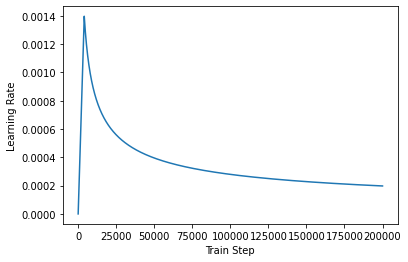

In [41]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [42]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 여기도 y_pred의 길이에 맞춰 y_true를 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [43]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 15s 47ms/step - loss: 7.8428 - accuracy: 0.5520
Epoch 2/10
185/185 [==============================] - 9s 47ms/step - loss: 4.4687 - accuracy: 0.6814
Epoch 3/10
185/185 [==============================] - 9s 47ms/step - loss: 2.0940 - accuracy: 0.7754
Epoch 4/10
185/185 [==============================] - 9s 47ms/step - loss: 1.7508 - accuracy: 0.7861
Epoch 5/10
185/185 [==============================] - 9s 47ms/step - loss: 1.6213 - accuracy: 0.7927
Epoch 6/10
185/185 [==============================] - 9s 47ms/step - loss: 1.5144 - accuracy: 0.7986
Epoch 7/10
185/185 [==============================] - 9s 47ms/step - loss: 1.3947 - accuracy: 0.8072
Epoch 8/10
185/185 [==============================] - 9s 47ms/step - loss: 1.2646 - accuracy: 0.8190
Epoch 9/10
185/185 [==============================] - 9s 47ms/step - loss: 1.1288 - accuracy: 0.8344
Epoch 10/10
185/185 [==============================] - 9s 47ms/step - loss: 0.9877 - accur

### 10번만 더해보자

Epoch 1/10
185/185 [==============================] - 9s 48ms/step - loss: 0.8421 - accuracy: 0.8669
Epoch 2/10
185/185 [==============================] - 9s 47ms/step - loss: 0.6923 - accuracy: 0.8854
Epoch 3/10
185/185 [==============================] - 9s 48ms/step - loss: 0.5487 - accuracy: 0.9050
Epoch 4/10
185/185 [==============================] - 9s 48ms/step - loss: 0.4211 - accuracy: 0.9236
Epoch 5/10
185/185 [==============================] - 9s 48ms/step - loss: 0.3087 - accuracy: 0.9430
Epoch 6/10
185/185 [==============================] - 9s 48ms/step - loss: 0.2186 - accuracy: 0.9585
Epoch 7/10
185/185 [==============================] - 9s 48ms/step - loss: 0.1498 - accuracy: 0.9717
Epoch 8/10
185/185 [==============================] - 9s 48ms/step - loss: 0.1076 - accuracy: 0.9793
Epoch 9/10
185/185 [==============================] - 9s 48ms/step - loss: 0.0822 - accuracy: 0.9837
Epoch 10/10
185/185 [==============================] - 9s 49ms/step - loss: 0.0688 - accura

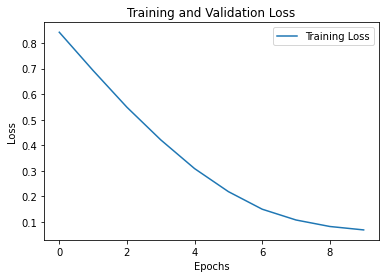

In [61]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

# 손실 저장
loss = history.history['loss']
val_loss = history.history.get('val_loss', None) # VAL 존재x

plt.plot(range(EPOCHS), loss, label='Training Loss')
if val_loss is not None:
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 그래프로는 뭔가 수상쩍은데 일단 진행해보자.

In [62]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [63]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [67]:
sentence_generation("죽고싶다...")

입력 : 죽고싶다...
출력 : 제가 곁에 있을게요.


'제가 곁에 있을게요.'

In [68]:
sentence_generation("안녕?")

입력 : 안녕?
출력 : 안녕하세요.


'안녕하세요.'

In [71]:
sentence_generation("너 바보야?")

입력 : 너 바보야?
출력 : 저는 위로봇입니다.


'저는 위로봇입니다.'

In [75]:
sentence_generation("위로 해줘")

입력 : 위로 해줘
출력 : 제게 기대세요.


'제게 기대세요.'

In [76]:
sentence_generation("고맙다")

입력 : 고맙다
출력 : 감사합니다.


'감사합니다.'

In [77]:
sentence_generation("오늘 날씨 어때?")

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요.


'날씨 어플에 물어보세요.'

### 생각보다 성능이 좋다. 데이터셋이 굉장히 단순하기 때문일 것
* 데이터셋이 굉장히 늘어났을때가 궁금해지는 실습이었다